## Image Segementation Study: Segmentating water bodies from Satelite Images
There are three layers for this project:
1. Building Vanila Unet from Sketch using Unet : Getting a throughout and depper understanding of what and how Unet is working under the hood
2. Using Transfer Learning from other pretrained model to see how much better when using more advanced and complex model
3. Using Transformer accompanied model to see how much better it can get.

This is the part one of the project: Building the Unet from Sketch in pytorch

The original inspiration of this project is to apply a image classification to real time vidoe streaming of wedges which can monitor the overflow and spillage, provide real time alert system and saving manhours in monitoring the spillage.

This project is an extension of the inspiration , which is to identify not only spillage, but also the capacity of segmenting the water surface and dry surface which extend the capacity of simple boolean alert system and a more information intensive alert and recording system.

## 0.0 - Importing the required modules 

In [2]:
import os 
import numpy as np
from tqdm.auto import tqdm
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub

In [3]:
import torch
import torchvision
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from torch.autograd import detect_anomaly
from torch.utils.tensorboard import SummaryWriter
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-06-26 14:32:36.450548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750948356.740427      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750948356.818180      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


device(type='cpu')

In [4]:
torch.cuda.empty_cache()

## 0.1 - Importing training data
### This project utilize the image dataset from kagglehub which provide the image and the mask of water boides in satellite images :
here is the link to the kaggle dataset : [satellite images fo water boides](https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies)

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("franciscoescobar/satellite-images-of-water-bodies")

print("Path to dataset files:", path)

img_folder = path+"/Water Bodies Dataset/Images"
mask_folder = path+"/Water Bodies Dataset/Masks"

images_name = sorted(os.listdir(img_folder))
masks_name = sorted(os.listdir(mask_folder))

# creating a list of links to images and mask
image_files_list  = [os.path.join(img_folder,img_name) for img_name in images_name]
mask_files_list  = [os.path.join(mask_folder,mask_name) for mask_name in masks_name]

Path to dataset files: /kaggle/input/satellite-images-of-water-bodies


## 1.1- Basic data exploratory

In [12]:
#checking the images mode and size
img = Image.open(image_files_list[15])
img.mode , img.size

('RGB', (150, 231))

In [13]:
# checking the mask image mode and size
mask = Image.open(mask_files_list[15])
mask.mode , mask.size

('RGB', (150, 231))

### The mask images are RGB images instead of a one channel greyscale image or a tensor with labelling, transformation is needed to change it to a one layer tensor
 - Pillow.image.convert('L') would be used to converting it to a greyscale
 - The value of the single channeld image would then be devided by 255.0 and round() to get a categorical labelled images

## 1.2 Plotting 10 random images and their masks to sense check the images and masks

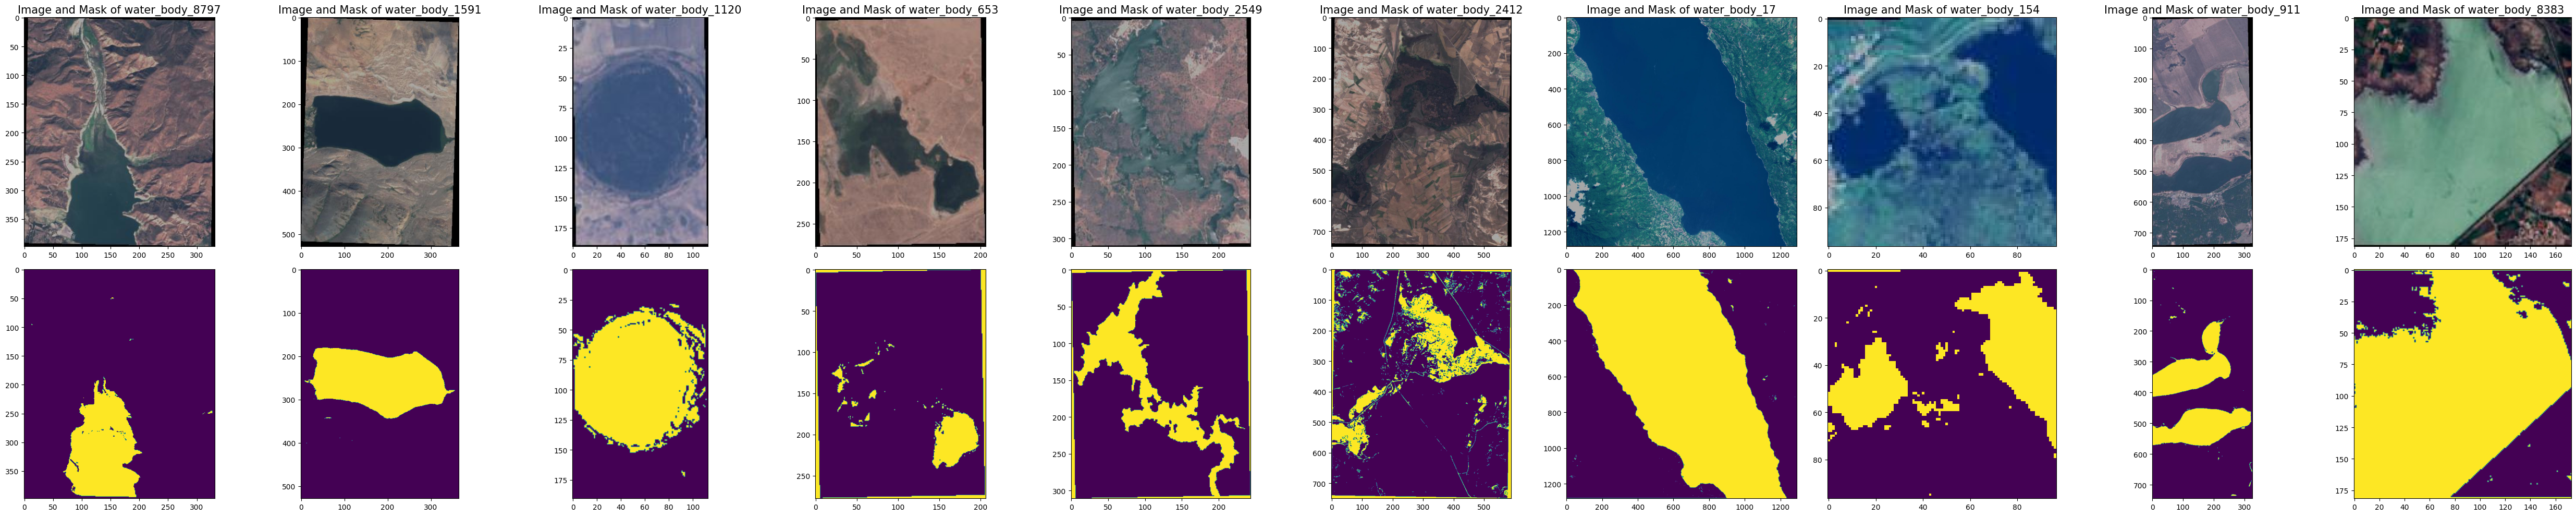

In [29]:
# plotting 10 random images and masks
fig,axs = plt.subplots(2,10, figsize= (50,10))
ax = axs.flatten()
random.seed(42)

for i,j in zip(range(10),random.sample(range(len(image_files_list)),k=10)):
    ax[i].set_title(f'Image and Mask of {image_files_list[j].split("/")[-1][:-4]}', fontsize=15)
    ax[i].imshow(np.array(Image.open(image_files_list[j])))
    
    # applying transformation to the mask files to one channel files with values 0 or 1 as label
    ax[i+10].imshow(np.round(np.array(Image.open(mask_files_list[j]).convert('L'))/255.0))
    
plt.tight_layout()
plt.show()



### One issue noted:  when the shape of image is not rectangular , the edges are randomly shown as water bodies or ground in the images, which could increase the error during the learning.
(see images water_body_1591 (2nd column) and water_body_653 (4th column) 



### One approach is setting up the threshold to the image files whenever the mean of RGB is below certain threshold , but it doesn't seem to be very effective as the edge are not entirely black and more like grey-blackish

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


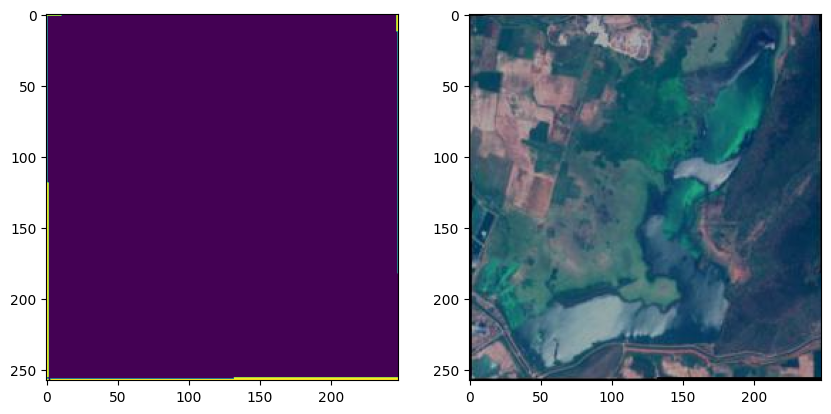

In [94]:
edge_threshold = 0.09
fig,ax = plt.subplots(1,2, figsize= (10,8))
ax = ax.flatten()
ax[0].imshow(np.array(Image.open(image_files_list[1728])).mean(axis=2)/255.0<edge_threshold)
ax[1].imshow(np.array(Image.open(image_files_list[1728])))

### Another quick and cleaner approach is by cropping only the centre 90% of the images which will be applied in the transformation

## 2.1 - Creatiing Dataset and Dataloader

In [100]:
transform= A.Compose([
    # resizing to (256*1.05 = 282) *282 image and apply centre crop to 256 for removing the unwanted edges
    A.Resize(282,282,1.0),
    A.CenterCrop(height=256,width=256,p=1.0),

    # applying random horiztonal flipping 
    A.HorizontalFlip(p=0.5),
    
    # other approaches for creating synthetic data 
    # transforms.ColorJitter(brightness=0.2,contrast=0.2),
    # transforms.RandomAffine(degrees=15, scale=(0.95,1.05), translate=(0.05,0.05)),

    # A.normalize input is (height,width,3) for RGB and (height,width,1) for greyscale
    # different from torchvision.transforms.functional.noramlize()
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.pytorch.ToTensorV2()
    
])

In [101]:
#creating data class

class WaterDataset(Dataset):
    def __init__ (self, img_list, mask_list, transform= None):
        self.img_list = img_list
        self.mask_list = mask_list
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image_path, mask_path  = self.img_list[idx] , self.mask_list[idx]

        img = np.array(Image.open(image_path),dtype=np.float32)
        img = img/255.0 

        mask = np.array(Image.open(mask_path).convert('L'),dtype=np.float32)
        mask = mask/255.0
        
        # print(img.shape, mask.shape)
        if self.transform :
            transformed  = self.transform(image=img,mask = mask)
            img = transformed['image']
            mask = transformed['mask']

        else:
            
            img , mask = torch.tensor(img).permute(2,0,1),torch.tensor(mask)
            img = torchvision.transforms.functional.normalize(img,(0.5,0.5,0.5),(0.5,0.5,0.5))
        
        mask=mask.unsqueeze(0)
        return img, mask


            

### Splitting the data , having 80% of the images as training data

In [102]:
from  sklearn.model_selection import train_test_split
X_train , X_val , y_train, y_val = train_test_split(image_files_list, mask_files_list,test_size = 0.2 , random_state=42)

In [103]:
train_dataset = WaterDataset (X_train,y_train,transform=transform)
test_dataset = WaterDataset (X_val,y_val,transform = transform)

train_loader = DataLoader(train_dataset,batch_size= 32 , num_workers = 4 , shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32 , num_workers =4 , shuffle = True)


In [104]:
# checking the shapes of the tensors
check_img , check_mask = train_dataset[2]
## check_img , check_mask = train_dataset[2]
check_img.shape, check_mask.shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

## Creating the blocks and backbone of the Unet from Sketch 

In [105]:
from torch import nn

# the horiztonal block 
class horizontal (nn.Module):
    def __init__ (self, channel_in, channel_out):
        super().__init__()
        # ouput_size = [(input_size -kennel_size +2* padding)/ stride] +1
        self.conv = nn.Sequential(
            # padding is created as opposed to the original paper to simplified the calculation
            nn.Conv2d(channel_in,channel_out,3,padding=1),
            nn.BatchNorm2d(channel_out),
            
            # padding is created as opposed to the original paper to simplified the calculation
            nn.Conv2d(channel_out,channel_out,3,padding=1),
            nn.BatchNorm2d(channel_out),
            
            # LeakyReLU was used to help with Vanishing Gradient 
            nn.LeakyReLU(negative_slope=0.01)
            # nn.ReLU(inplace=True)
        )

    def forward (self, x):
        return self.conv(x)
        
# the downsizing block 
class downward (nn.Module):
    def __init__ (self, channel_in , channel_out):
        super().__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            horizontal(channel_in,channel_out)
        )
    
    def forward (self,x):
        return self.down(x)

# the horiztonal block 
class upward (nn.Module):
    def __init__ (self, channel_in,channel_out):
        super().__init__()
        # output = stride * (input_size -1) + Kernel_size() - 2*padding
        self.up = nn.ConvTranspose2d(channel_in, channel_in //2 , 2, stride =2)
        self.horizontal = horizontal(channel_in,channel_out)

    def forward(self,x1, x2):
        x1 = self.up(x1)
        # diff_y = x2.size()[2] - x1.size()[2]
        # diff_x = x2.size()[3] - x1.size()[3]
        # x1 = torch.nn.functional.pad(x1,[diff_x//2, diff_x -diff_x//2 , diff_y//2, diff_y-diff_y//2])
        x2 = torch.cat([x2,x1], dim=1)

        return self.horizontal(x2)

# the horiztonal block 
class OutputMap (nn.Module):
    def __init__(self, channel_in,channel_out):
        super().__init__()
        self.out = nn.Sequential(
            nn.Conv2d(channel_in,channel_out,1)
            # output is logit for better loss calculation
        )

    def forward(self,x):
        return self.out(x)

class UNet (nn.Module):
    def __init__ (self, n_channels , n_classes):
        super().__init__()
        self.horizontal1 = horizontal(n_channels,64)
        self.down1 = downward(64,128)
        self.down2 = downward(128,256)
        self.down3 = downward(256,512)
        self.down4 = downward(512,1024)
        self.up1 = upward(1024,512)
        self.up2 = upward(512,256)
        self.up3 = upward(256,128)
        self.up4 = upward(128,64)
        self.outc = OutputMap (64, n_classes)

    def forward(self,x):
        x1 = self.horizontal1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5,x4)
        x = self.up2(x,x3)
        x = self.up3(x,x2)
        x = self.up4(x,x1)
        logits = self.outc(x)

        return logits

In [106]:
# # printing the summary to check for error
from torchsummary import summary
model = UNet(3,1)
summary(model,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
            Conv2d-3         [-1, 64, 256, 256]          36,928
       BatchNorm2d-4         [-1, 64, 256, 256]             128
         LeakyReLU-5         [-1, 64, 256, 256]               0
        horizontal-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
           Conv2d-10        [-1, 128, 128, 128]         147,584
      BatchNorm2d-11        [-1, 128, 128, 128]             256
        LeakyReLU-12        [-1, 128, 128, 128]               0
       horizontal-13        [-1, 128, 128, 128]               0
         downward-14        [-1, 128, 1

### creating loss function 
- Loss function is created by combining the BCE loss and DICE loss
- The weight for BCE loss and DICE loss are referenced from a paper

In [15]:
# Using the sum of DiceLoss and BCELoss as the Loss function

#dice_loss
def dice_loss (pred,target,epsilon=1e-6):

    pred = torch.sigmoid(pred)
       
    intersection = (pred * target).sum()
    dice = (2.0 * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)
    return 1 - dice

#Creating combinedLoss 
class CombinedLoss(nn.Module):
    def __init__(self,bce_weight=0.6,beta=0.7):
        super().__init__()

        self.bce_loss= nn.BCEWithLogitsLoss()
        # self.bce_loss= nn.BCELoss()

        self.bce_weight = bce_weight
    
    def forward(self,logits,targets,return_individual=True):
        
        dice = dice_loss(logits,targets)
        
        bce = self.bce_loss(logits,targets)
        # iou = jaccard_loss(logits,targets)
        combined = (1-self.bce_weight)*dice + (self.bce_weight)*bce

        if return_individual:
            return combined, dice, bce
        return combined



### This grad flow plot is copied from the pytorch forum [Check gradient flow in network](https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063) for visualising the the gradient flow and check against any expanding or vanishing gradient

In [16]:
from matplotlib.lines import Line2D
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
            max_grads.append(p.grad.abs().max().cpu())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    plt.show()


## Training Functions

In [17]:
## Training Function
def train(model, train_loader, val_loader, optimizer, criterion, epochs,scheduler=None):
    train_losses, val_losses = [], []
    train_dice_losses, val_dice_losses = [], []
    train_bce_losses, val_bce_losses = [], []
    
    # scaler is added for dynamic learning rate
    scaler = torch.amp.GradScaler('cuda')
    
    for epoch in tqdm(range(epochs),desc="Epoch",position=0, leave=True):
        
        model.train()
        # resetting the loss for each full batch propagations
        total_training_loss ,total_training_dice ,total_training_bce = 0.0 , 0.0 , 0.0
        
        for  images, masks in tqdm(train_loader,desc="training_batch",position=1, leave=True):
            
            images , masks = images.to(device) , masks.to(device)        

            optimizer.zero_grad() 
            with torch.amp.autocast('cuda'):
                output = model(images)
                total_loss, dice_component, bce_component = criterion(output, masks, return_individual=True)
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()

            ### added to check if there is any nan or exploding gradient
            # with detect_anomaly():
            # logits = model(images)
            # loss  = criterion(logits,masks)
            # optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()
            
            total_training_loss += total_loss.item()
            total_training_dice += dice_component.item()
            total_training_bce += bce_component.item()
            
        # plotting images, mask and predictions every 5 epoch
        if epoch %5 ==0:
            plot_sample_images(images,masks,model,epoch)
                      
        # gradient flow and check for vanishing gradient at the 2nd epoch
        if epoch ==2:
            plot_grad_flow(model.named_parameters())  
        
        # Calculate and append training loss each epoch
        train_loss_this_epoch = total_training_loss / len(train_loader)
        train_dice_this_epoch = total_training_dice / len(train_loader)
        train_bce_this_epoch = total_training_bce / len(train_loader)
        
        train_losses.append(train_loss_this_epoch)
        train_dice_losses.append(train_dice_this_epoch)
        train_bce_losses.append(train_bce_this_epoch)
        # writer.add_scalar("Loss/train", train_loss_this_epoch, epoch)

        if scheduler is not None:
            scheduler.step()
        
        model.eval()
        total_val_loss, total_val_dice, total_val_bce  = 0.0 , 0.0, 0.0
        
        with torch.no_grad():
            for images,masks in tqdm(val_loader,desc="val_batch",position=2, leave=True):
                images, masks = images.to(device) , masks.to(device)
                
                logits = model(images)
                total_loss, dice_component, bce_component = criterion(logits, masks, return_individual=True)
                
                total_val_loss += total_loss.item()
                total_val_dice += dice_component.item()
                total_val_bce += bce_component.item()
                
        if epoch %5 ==0:
            plot_sample_images(images,masks,model,epoch)

        # Calculate and append validation loss each epoch
        val_loss_this_epoch = total_val_loss / len(val_loader)
        val_dice_this_epoch = total_val_dice / len(val_loader)
        val_bce_this_epoch = total_val_bce / len(val_loader)
        
        val_losses.append(val_loss_this_epoch)
        val_dice_losses.append(val_dice_this_epoch)
        val_bce_losses.append(val_bce_this_epoch)

        print(f'Epoch: {epoch+1}/{epochs}')
        print(f'  Train - Total: {train_loss_this_epoch:.4f}, Dice: {train_dice_this_epoch:.4f}, BCE: {train_bce_this_epoch:.4f}')
        print(f'  Val   - Total: {val_loss_this_epoch:.4f}, Dice: {val_dice_this_epoch:.4f}, BCE: {val_bce_this_epoch:.4f}')
        print('-' * 80)
        
    return [train_losses , train_dice_losses,train_bce_losses], [val_losses ,val_dice_losses,val_bce_losses]


In [18]:
# definition for plotting the image , mask and predictions
def plot_sample_images(images,masks,model,epoch):
    fig, axes = plt.subplots(1, 3, figsize=(5, 3))
    # fig.suptitle(f'Epoch {epoch + 1} - Detailed Predictions', fontsize=16)
    
    ax=axes.flatten()
    img_np = images[3].cpu().permute(1,2,0)
    mean = np.array([0.485, 0.456, 0.406]).reshape(1, 1, 3)
    std = np.array([0.229, 0.224, 0.225]).reshape(1, 1, 3)
    img_np = img_np * std + mean
    
    mask_np = masks[3].cpu().permute(1,2,0)
    
    with torch.no_grad():
        logits = model(images[3].cpu().unsqueeze(0))
        prediction = torch.sigmoid(logits[0])
        #setting threshold as 0.5
        prediction=(prediction > 0.5)*1.0
    
    
    ax[0].imshow(img_np*255.0)
    ax[0].set_title('Original Images')
    ax[1].imshow(mask_np*255.0, cmap='gray')
    ax[1].set_title('Mask')
    ax[2].imshow(prediction.permute(1,2,0).cpu().numpy()*255.0)
    ax[2].set_title('Model Prediction')

    plt.tight_layout()
    plt.show()

In [19]:
''' Forward hook for testing if the output is correct'''
# model = UNet(3,1)

# # forward hook testing
# def hook_fn(module , input, output):
#     print(f"Layer : {module} , Output Shape: {output.shape}")

# for layer in model.children():
#     layer.register_forward_hook(hook_fn)

# dummy_input = torch.randn(3,3,256,256)
# model(dummy_input)

' Forward hook for testing if the output is correct'

## 1st trial in training the model


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

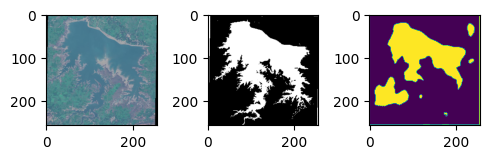

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

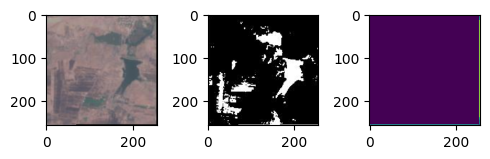

Epoch: 1/10
  Train - Total: 0.5064, Dice: 0.4684, BCE: 0.5317
  Val   - Total: 1.3627, Dice: 0.9317, BCE: 1.6500
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2/10
  Train - Total: 0.4333, Dice: 0.4050, BCE: 0.4522
  Val   - Total: 0.7530, Dice: 0.7771, BCE: 0.7369
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3/10
  Train - Total: 0.4079, Dice: 0.3760, BCE: 0.4293
  Val   - Total: 0.6332, Dice: 0.6865, BCE: 0.5977
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4/10
  Train - Total: 0.3955, Dice: 0.3626, BCE: 0.4174
  Val   - Total: 0.6160, Dice: 0.6497, BCE: 0.5935
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5/10
  Train - Total: 0.3834, Dice: 0.3484, BCE: 0.4067
  Val   - Total: 1.5847, Dice: 0.5212, BCE: 2.2937
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

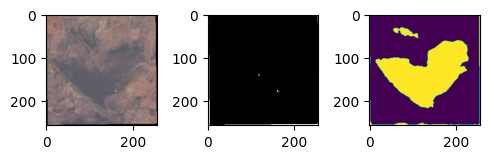

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

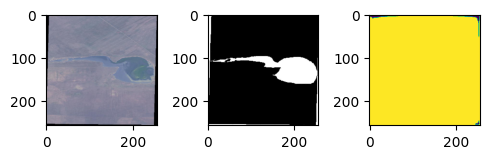

Epoch: 6/10
  Train - Total: 0.3856, Dice: 0.3492, BCE: 0.4099
  Val   - Total: 1.9858, Dice: 0.5146, BCE: 2.9666
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 7/10
  Train - Total: 0.3750, Dice: 0.3380, BCE: 0.3997
  Val   - Total: 0.9274, Dice: 0.5100, BCE: 1.2056
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 8/10
  Train - Total: 0.3729, Dice: 0.3357, BCE: 0.3977
  Val   - Total: 7.5688, Dice: 0.5168, BCE: 12.2702
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 9/10
  Train - Total: 0.3720, Dice: 0.3348, BCE: 0.3967
  Val   - Total: 5.6740, Dice: 0.5164, BCE: 9.1125
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 10/10
  Train - Total: 0.3620, Dice: 0.3236, BCE: 0.3876
  Val   - Total: 10.4583, Dice: 0.5157, BCE: 17.0867
--------------------------------------------------------------------------------


In [20]:
# initializing the model and allowing for 2 GPU in parallel
model = UNet(3,1)
model = nn.DataParallel(model)
model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  
criterion = CombinedLoss()
epochs = 10

train_losses, val_losses = train(model, train_loader, test_loader, optimizer,criterion,epochs)

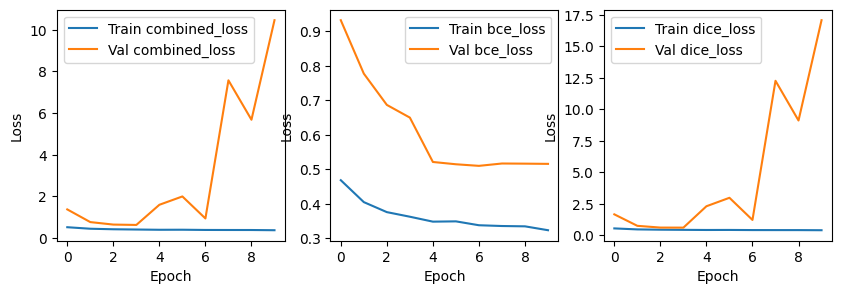

In [21]:
fig,axs = plt.subplots(1,3,figsize=(10,3))
ax= axs.flatten()
i=0
for train_losses,val_losses, label in zip (train_losses, val_losses,['combined_loss','bce_loss','dice_loss']):
    ax[i].plot(np.arange(epochs), train_losses)
    ax[i].plot(np.arange(epochs), val_losses)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Loss")
    ax[i].legend([f"Train {label}", f"Val {label}"])
    i+=1
plt.show()

### Model getting stuck in suboptimal regions during the first few epochs of training with Adam and the validation error is eploding
- Which can be due to the learning rate is too large and not scaling down accordingly

In [22]:
# clearing the cache in GPUs
torch.cuda.empty_cache()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

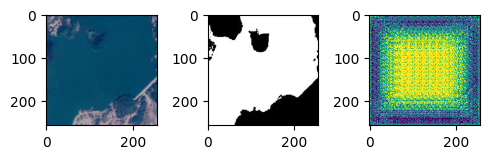

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

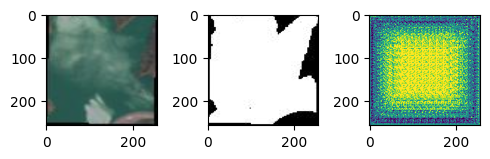

Epoch: 1/10
  Train - Total: 1.1257, Dice: 0.5582, BCE: 1.5040
  Val   - Total: 0.9196, Dice: 0.5563, BCE: 1.1618
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2/10
  Train - Total: 0.7454, Dice: 0.5422, BCE: 0.8808
  Val   - Total: 0.6752, Dice: 0.5232, BCE: 0.7765
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3/10
  Train - Total: 0.5855, Dice: 0.5251, BCE: 0.6258
  Val   - Total: 0.6456, Dice: 0.4916, BCE: 0.7483
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4/10
  Train - Total: 0.5203, Dice: 0.4793, BCE: 0.5477
  Val   - Total: 0.6698, Dice: 0.4691, BCE: 0.8036
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5/10
  Train - Total: 0.4718, Dice: 0.4347, BCE: 0.4965
  Val   - Total: 0.8573, Dice: 0.4699, BCE: 1.1156
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

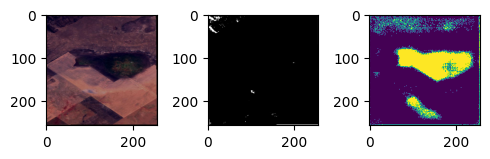

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

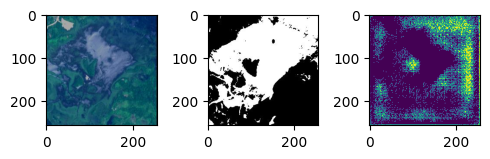

Epoch: 6/10
  Train - Total: 0.4434, Dice: 0.4055, BCE: 0.4686
  Val   - Total: 0.4692, Dice: 0.4747, BCE: 0.4656
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 7/10
  Train - Total: 0.4256, Dice: 0.3863, BCE: 0.4518
  Val   - Total: 0.5720, Dice: 0.5808, BCE: 0.5661
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 8/10
  Train - Total: 0.4153, Dice: 0.3764, BCE: 0.4413
  Val   - Total: 1.6481, Dice: 0.4964, BCE: 2.4159
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 9/10
  Train - Total: 0.4014, Dice: 0.3605, BCE: 0.4287
  Val   - Total: 0.5563, Dice: 0.5651, BCE: 0.5504
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 10/10
  Train - Total: 0.3918, Dice: 0.3529, BCE: 0.4177
  Val   - Total: 0.7047, Dice: 0.4009, BCE: 0.9072
--------------------------------------------------------------------------------


In [23]:
# model1 = UNet(3,1)
# model1 = nn.DataParallel(model1)
# model1.to(device)

# # using he initialisation to help with vanishing gradient
# def he_init(layer):
#     if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
#         nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='leaky_relu')
#     elif isinstance(layer, nn.BatchNorm2d):
#         nn.init.constant_(layer.weight, 1)
#         nn.init.constant_(layer.bias, 0)

# model1.apply(he_init)

# optimizer = torch.optim.RAdam(model1.parameters(), lr=0.00001, weight_decay=1e-3)
# # changed from 0.001 as it had shown some slower

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# criterion = CombinedLoss()
# epochs = 10

# train_losses_list1, val_losses_list1 = train(model1, train_loader, test_loader, optimizer,criterion,epochs,scheduler)

In [24]:
# torch.save(model.state_dict(),"test_model.pt")

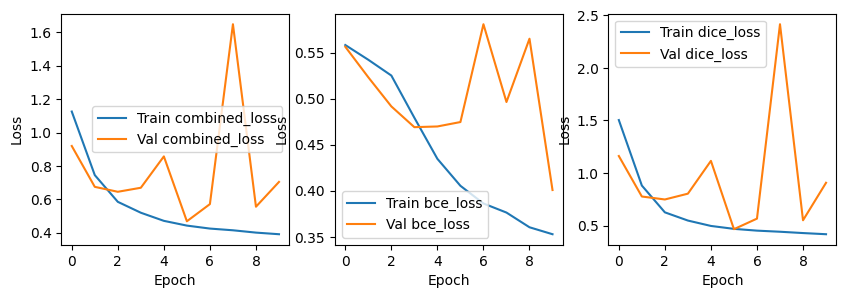

In [25]:
# fig,axs = plt.subplots(1,3,figsize=(10,3))
# ax= axs.flatten()
# i=0
# for train_losses,val_losses, label in zip (train_losses_list1, val_losses_list1,['combined_loss','bce_loss','dice_loss']):
#     ax[i].plot(np.arange(epochs), train_losses)
#     ax[i].plot(np.arange(epochs), val_losses)
#     ax[i].set_xlabel("Epoch")
#     ax[i].set_ylabel("Loss")
#     ax[i].legend([f"Train {label}", f"Val {label}"])
#     i+=1
# plt.show()

In [26]:
# plt.savefig(f'epoch_30_detailed_predictions.png', dpi=300, bbox_inches='tight')

In [27]:
torch.cuda.empty_cache()

## 2nd Trial for model training 
### Changes included :
1. Using Kaiming Initilization for better intialization of weight for leaky relu and BatchNorm which can help with faster training
2. Reducing the learning rate from 0.001 to 0.0001
3. Using AdamW for better weight decay and optimization
4. Using Learning Rate step scheduler to reducing the learning rate in later epochs

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

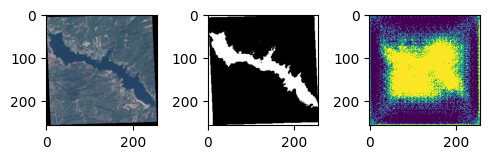

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

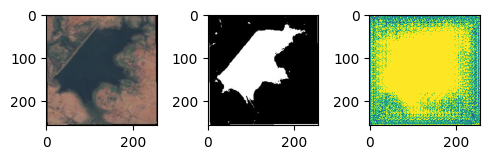

Epoch: 1/30
  Train - Total: 0.9539, Dice: 0.5346, BCE: 1.2335
  Val   - Total: 0.8062, Dice: 0.5276, BCE: 0.9919
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2/30
  Train - Total: 0.5072, Dice: 0.4651, BCE: 0.5352
  Val   - Total: 0.6115, Dice: 0.4593, BCE: 0.7130
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3/30
  Train - Total: 0.4450, Dice: 0.4076, BCE: 0.4700
  Val   - Total: 0.5624, Dice: 0.5348, BCE: 0.5808
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4/30
  Train - Total: 0.4241, Dice: 0.3876, BCE: 0.4485
  Val   - Total: 0.8163, Dice: 0.7828, BCE: 0.8387
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5/30
  Train - Total: 0.4122, Dice: 0.3734, BCE: 0.4380
  Val   - Total: 0.5832, Dice: 0.3964, BCE: 0.7076
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

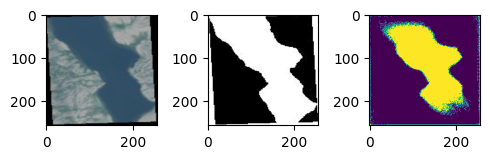

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

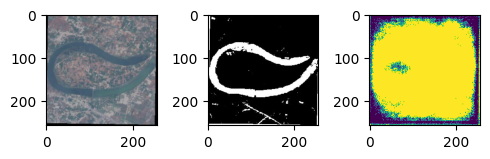

Epoch: 6/30
  Train - Total: 0.4038, Dice: 0.3657, BCE: 0.4293
  Val   - Total: 1.0861, Dice: 0.4546, BCE: 1.5071
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 7/30
  Train - Total: 0.3906, Dice: 0.3528, BCE: 0.4157
  Val   - Total: 0.7255, Dice: 0.6987, BCE: 0.7433
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 8/30
  Train - Total: 0.3921, Dice: 0.3527, BCE: 0.4184
  Val   - Total: 0.4265, Dice: 0.4273, BCE: 0.4259
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 9/30
  Train - Total: 0.3796, Dice: 0.3407, BCE: 0.4055
  Val   - Total: 0.6880, Dice: 0.6852, BCE: 0.6898
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 10/30
  Train - Total: 0.3702, Dice: 0.3321, BCE: 0.3957
  Val   - Total: 0.4683, Dice: 0.4818, BCE: 0.4592
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

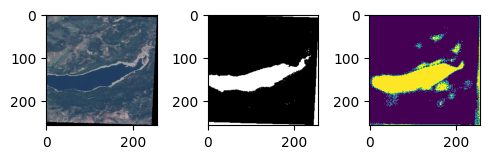

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

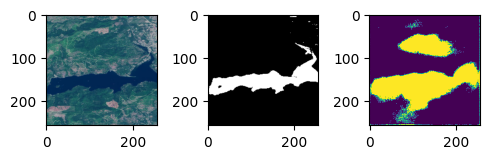

Epoch: 11/30
  Train - Total: 0.3597, Dice: 0.3243, BCE: 0.3833
  Val   - Total: 0.5482, Dice: 0.3694, BCE: 0.6673
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 12/30
  Train - Total: 0.3572, Dice: 0.3228, BCE: 0.3800
  Val   - Total: 0.4076, Dice: 0.3384, BCE: 0.4537
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 13/30
  Train - Total: 0.3582, Dice: 0.3229, BCE: 0.3817
  Val   - Total: 0.4234, Dice: 0.3355, BCE: 0.4821
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 14/30
  Train - Total: 0.3522, Dice: 0.3184, BCE: 0.3748
  Val   - Total: 0.4270, Dice: 0.3319, BCE: 0.4905
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 15/30
  Train - Total: 0.3537, Dice: 0.3167, BCE: 0.3783
  Val   - Total: 0.3537, Dice: 0.3190, BCE: 0.3769
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

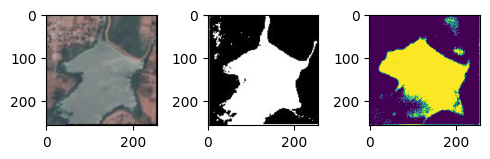

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

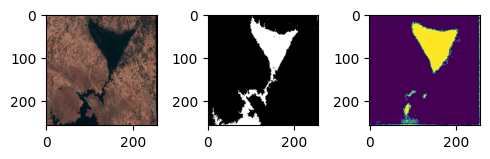

Epoch: 16/30
  Train - Total: 0.3494, Dice: 0.3141, BCE: 0.3730
  Val   - Total: 0.3818, Dice: 0.3243, BCE: 0.4201
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 17/30
  Train - Total: 0.3497, Dice: 0.3144, BCE: 0.3732
  Val   - Total: 0.3693, Dice: 0.3163, BCE: 0.4046
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 18/30
  Train - Total: 0.3471, Dice: 0.3120, BCE: 0.3706
  Val   - Total: 0.3424, Dice: 0.3195, BCE: 0.3576
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 19/30
  Train - Total: 0.3455, Dice: 0.3081, BCE: 0.3705
  Val   - Total: 0.3482, Dice: 0.3278, BCE: 0.3618
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 20/30
  Train - Total: 0.3470, Dice: 0.3119, BCE: 0.3703
  Val   - Total: 0.4146, Dice: 0.3179, BCE: 0.4791
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

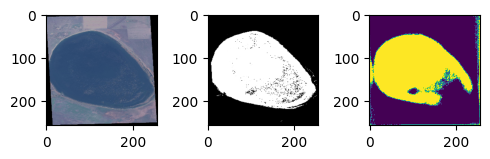

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

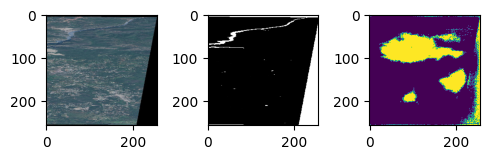

Epoch: 21/30
  Train - Total: 0.3444, Dice: 0.3081, BCE: 0.3686
  Val   - Total: 0.3865, Dice: 0.3159, BCE: 0.4337
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 22/30
  Train - Total: 0.3461, Dice: 0.3097, BCE: 0.3704
  Val   - Total: 0.4164, Dice: 0.3214, BCE: 0.4798
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 23/30
  Train - Total: 0.3460, Dice: 0.3093, BCE: 0.3705
  Val   - Total: 0.3843, Dice: 0.3145, BCE: 0.4308
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 24/30
  Train - Total: 0.3459, Dice: 0.3084, BCE: 0.3709
  Val   - Total: 0.3981, Dice: 0.3172, BCE: 0.4520
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 25/30
  Train - Total: 0.3451, Dice: 0.3095, BCE: 0.3688
  Val   - Total: 0.4101, Dice: 0.3208, BCE: 0.4696
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

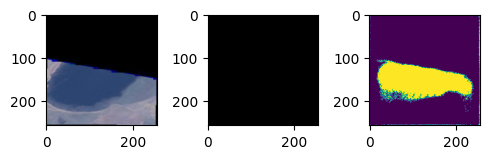

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

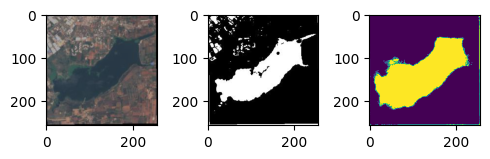

Epoch: 26/30
  Train - Total: 0.3444, Dice: 0.3095, BCE: 0.3677
  Val   - Total: 0.3690, Dice: 0.3129, BCE: 0.4064
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 27/30
  Train - Total: 0.3421, Dice: 0.3066, BCE: 0.3658
  Val   - Total: 0.3796, Dice: 0.3153, BCE: 0.4224
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 28/30
  Train - Total: 0.3446, Dice: 0.3100, BCE: 0.3676
  Val   - Total: 0.3954, Dice: 0.3197, BCE: 0.4458
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 29/30
  Train - Total: 0.3420, Dice: 0.3064, BCE: 0.3658
  Val   - Total: 0.4143, Dice: 0.3241, BCE: 0.4744
--------------------------------------------------------------------------------


training_batch:   0%|          | 0/71 [00:00<?, ?it/s]

val_batch:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 30/30
  Train - Total: 0.3421, Dice: 0.3071, BCE: 0.3654
  Val   - Total: 0.4379, Dice: 0.3282, BCE: 0.5109
--------------------------------------------------------------------------------


In [21]:
model2 = UNet(3,1)
model2 = nn.DataParallel(model2)
model2.to(device)

# using he initialisation to help with vanishing gradient
def he_init(layer):
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif isinstance(layer, nn.BatchNorm2d):
        nn.init.constant_(layer.weight, 1)
        nn.init.constant_(layer.bias, 0)

model2.apply(he_init)
epochs = 30

optimizer = torch.optim.AdamW(model2.parameters(), lr=0.00001, weight_decay=1e-3)
# optimizer = torch.optim.RAdam(model.parameters(), lr=0.00001, weight_decay=1e-3)
# changed from 0.001 as it had shown some slower

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs//3, gamma=0.1 )

criterion = CombinedLoss()


train_losses_list, val_losses_list = train(model2, train_loader, test_loader, optimizer,criterion,epochs,scheduler)

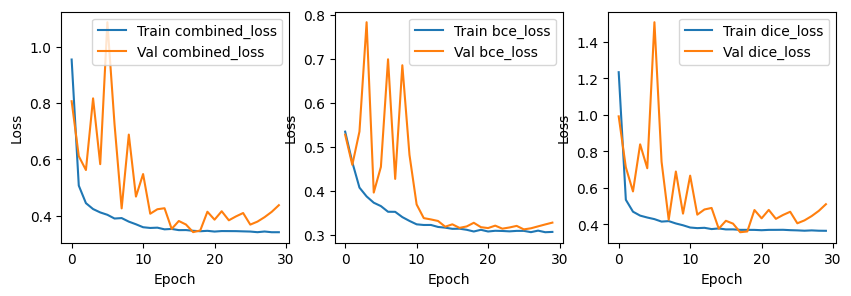

In [22]:
fig,axs = plt.subplots(1,3,figsize=(10,3))
ax= axs.flatten()
i=0
for train_losses,val_losses, label in zip (train_losses_list, val_losses_list,['combined_loss','bce_loss','dice_loss']):
    ax[i].plot(np.arange(epochs), train_losses)
    ax[i].plot(np.arange(epochs), val_losses)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Loss")
    ax[i].legend([f"Train {label}", f"Val {label}"])
    i+=1
plt.show()

In [ ]:
torch.cuda.empty_cache()

In [24]:
torch.save(model2.state_dict(), 'vanilla_unet_model.pth')

In [ ]:
from IPython.display import FileLink
FileLink(r''vanilla_unet_model.pth')

In [ ]:
# try replacing all the conv block in decoder to see if it helps 

In [ ]:
## efficient dense unet

#replacing all the expansion path conv blacks with DeenseNet

#i.e. effiecnet dense U-net